In [1]:
!pip install -U bitsandbytes
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
# =========================================================================
# Bước 1: Thiết lập môi trường và Cài đặt ban đầu
# =========================================================================
import os
import torch
import time
from torch.utils.data import Dataset
from transformers import (
    AutoProcessor,
    AutoModelForImageTextToText,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
from typing import Dict, List, Any
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2025-11-16 10:06:09.923991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763287570.161924      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763287570.222931      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import peft
print(peft.__version__)

0.16.0


In [4]:
# =========================================================================
# Bước 2: Hằng số và Định nghĩa Token (Theo yêu cầu của bạn)
# =========================================================================
IS_FIRST_TRAIN = False

IM_START_TOKEN = "<|im_start|>"
IM_END_TOKEN = "<|im_end|>"
IMAGE_TOKEN = "<image>"
VISION_START_TOKEN = "<|vision_start|>"
VISION_END_TOKEN = "<|vision_end|>"
IGNORE_INDEX = -100
IMAGE_INPUT_SIZE = (448, 448)
ADAPTER_REPO_ID = "sunbv56/qwen2.5-vl-vqa-vibook-tmp" 
BASE_MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
OUTPUT_DIR = "./qwen2.5-vl-finetune-checkpoints"

print(f"🚀 Chế độ huấn luyện: {'BẮT ĐẦU MỚI' if IS_FIRST_TRAIN else 'TIẾP TỤC (RESUME)'}")
print(f"📖 Model gốc: {BASE_MODEL_ID}")
print(f"🛠️ Repo Adapter/Checkpoint: {ADAPTER_REPO_ID}")

🚀 Chế độ huấn luyện: TIẾP TỤC (RESUME)
📖 Model gốc: Qwen/Qwen2.5-VL-3B-Instruct
🛠️ Repo Adapter/Checkpoint: sunbv56/qwen2.5-vl-vqa-vibook-tmp


In [5]:
# =========================================================================
# Bước 3: Thiết lập Model, Processor, Quantization và LoRA
# =========================================================================
print("🚀 Bắt đầu: Thiết lập Model và Processor...")
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

processor = AutoProcessor.from_pretrained(BASE_MODEL_ID, trust_remote_code=True)
model = AutoModelForImageTextToText.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    # device_map={'':torch.cuda.current_device()},
    trust_remote_code=True,
)

print(f"🖥️ Số lượng GPU được script sử dụng: {torch.cuda.device_count()}")

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=["img_projector"],
)

if IS_FIRST_TRAIN:
    print("\n🔥 Chế độ HUẤN LUYỆN MỚI: Áp dụng cấu hình LoRA mới cho model.")
    model = get_peft_model(model, lora_config)
else:
    print(f"\n🔁 Chế độ TIẾP TỤC: Tải adapter có sẵn từ repo '{ADAPTER_REPO_ID}'...")
    try:
        model = PeftModel.from_pretrained(model, ADAPTER_REPO_ID)
        print("✅ Đã tải và gắn adapter (PeftModel) thành công.")
    except Exception as e:
        print(f"❌ LỖI: Không thể tải adapter từ {ADAPTER_REPO_ID}.")
        print(f"   Lý do: {e}")
        print("   Vui lòng kiểm tra lại repo ID hoặc đảm bảo bạn đã đẩy adapter lên đó trước đây.")
        raise e

model.print_trainable_parameters()

🚀 Bắt đầu: Thiết lập Model và Processor...


preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

🖥️ Số lượng GPU được script sử dụng: 2

🔁 Chế độ TIẾP TỤC: Tải adapter có sẵn từ repo 'sunbv56/qwen2.5-vl-vqa-vibook-tmp'...


adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/149M [00:00<?, ?B/s]

✅ Đã tải và gắn adapter (PeftModel) thành công.
trainable params: 0 || all params: 3,791,775,744 || trainable%: 0.0000


# Preprocess Data

In [6]:
# =========================================================================
# Bước 4: Chuẩn bị Dataset (Sử dụng các token đã định nghĩa một cách an toàn)
# =========================================================================
class ImageSupervisedDataset(Dataset):
    def __init__(self, dataset: Any, processor: Any):
        self.dataset = dataset
        self.processor = processor
        self.eos_token = self.processor.tokenizer.eos_token
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        sources = self.dataset[i]
        try:
            image_raw = Image.open(requests.get(sources["image_url"], stream=True, timeout=15, headers=self.headers).raw).convert("RGB")
            image = image_raw.resize(IMAGE_INPUT_SIZE)
        except Exception as e:
            print(f"⚠️ Lỗi ảnh mẫu {i}: {e}. Bỏ qua.")
            return None

        conversations = sources.get('conversations')
        if not conversations or len(conversations) < 2:
            return None

        human_turn = conversations[0]
        gpt_turn = conversations[1]

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": human_turn['value']}
                ]
            }
        ]

        try:
            prompt_text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            prompt_inputs = self.processor(
                text=[prompt_text], images=[image], return_tensors='pt'
            )

            response_text = gpt_turn['value'] + self.eos_token
            response_ids = self.processor.tokenizer(
                response_text, add_special_tokens=False, return_tensors='pt'
            ).input_ids

            input_ids = torch.cat([prompt_inputs.input_ids, response_ids], dim=1)
            prompt_len = prompt_inputs.input_ids.shape[1]
            labels = torch.full_like(input_ids, IGNORE_INDEX)
            labels[:, prompt_len:] = response_ids

            final_inputs = {k: v.squeeze(0) for k, v in prompt_inputs.items()}
            final_inputs["input_ids"] = input_ids.squeeze(0)
            final_inputs["labels"] = labels.squeeze(0)
            return final_inputs

        except Exception as e:
            print(f"Lỗi processor mẫu {i}: {e}. Bỏ qua.")
            return None

class DataCollatorForImageDataset:
    def __init__(self, processor: Any):
        self.processor = processor
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features = [f for f in features if f is not None]
        if not features: return {}
        input_ids = torch.nn.utils.rnn.pad_sequence([f["input_ids"] for f in features], batch_first=True, padding_value=self.processor.tokenizer.pad_token_id)
        labels = torch.nn.utils.rnn.pad_sequence([f["labels"] for f in features], batch_first=True, padding_value=IGNORE_INDEX)
        attention_mask = (input_ids != self.processor.tokenizer.pad_token_id)
        pixel_values = torch.stack([f["pixel_values"] for f in features], dim=0)
        image_grid_thw = torch.stack([f["image_grid_thw"] for f in features], dim=0)
        return {"input_ids": input_ids, "labels": labels, "attention_mask": attention_mask, "pixel_values": pixel_values, "image_grid_thw": image_grid_thw}

print("✅ Class Dataset và Data Collator đã được định nghĩa.")

✅ Class Dataset và Data Collator đã được định nghĩa.


In [7]:
import random
from datasets import load_dataset
# (Giả sử bạn đã import ImageSupervisedDataset và DataCollatorForImageDataset)

# --- 1. Thiết lập CHUNK (Lát cắt) bạn muốn sử dụng ---
# n_start = 0
# n_end = 3999
n_start = 4000
n_end = 6999


print(f"📚 Bắt đầu: Tải và CHỌN chunk [index {n_start} - {n_end}]...")

# --- 2. Tải và CẮT (select) TRƯỚC ---
full_dataset = load_dataset("LR-AI-Labs/vi-OCR_VQA")["train"]

# Kiểm tra xem dataset có đủ dài không
if n_end >= len(full_dataset):
    print(f"CẢNH BÁO: Dataset chỉ có {len(full_dataset)} mẫu.")
    print(f"   Không thể lấy đến index {n_end}. Sẽ lấy đến hết.")
    n_end = len(full_dataset) - 1 # Lấy đến index cuối cùng

if n_start >= len(full_dataset):
    print(f"LỖI: Điểm bắt đầu ({n_start}) đã vượt quá độ dài dataset.")
    # raise ValueError("Start index is out of bounds.")
else:
    # Chọn CHUNK [3000, 6000]. +1 vì range() không bao gồm điểm cuối
    subset = full_dataset.select(range(n_start, n_end + 1))

    print(f"Đã CẮT: {len(subset)} mẫu (từ index {n_start} đến {n_end})")

    # --- 3. CHIA (split) SAU ---
    print(f"🔄 Đang CHIA {len(subset)} mẫu này thành 90% train / 10% eval...")

    # Chia cái subset (chunk 3000-6000) này ra 90/10
    # 10% eval sẽ được lấy NGẪU NHIÊN từ chunk này
    raw_dataset_split = subset.train_test_split(test_size=0.1, seed=42)

    train_split = raw_dataset_split["train"]
    eval_split = raw_dataset_split["test"]

    print(f"Kết quả cuối cùng:")
    print(f"train: {len(train_split)} mẫu") # 90% của chunk
    print(f"eval:  {len(eval_split)} mẫu (Lấy ngẫu nhiên từ chunk {n_start}-{n_end})")

    # --- 4. 🧱 Tạo dataset (Giữ nguyên) ---
    train_dataset = ImageSupervisedDataset(dataset=train_split, processor=processor)
    eval_dataset = ImageSupervisedDataset(dataset=eval_split, processor=processor)
    data_collator = DataCollatorForImageDataset(processor=processor)

    print(f"✅ Dataset (từ Chunk {n_start}-{n_end}) và Data Collator đã sẵn sàng!")

📚 Bắt đầu: Tải và CHỌN chunk [index 4000 - 6999]...


README.md:   0%|          | 0.00/167 [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/24.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33531 [00:00<?, ? examples/s]

Đã CẮT: 3000 mẫu (từ index 4000 đến 6999)
🔄 Đang CHIA 3000 mẫu này thành 90% train / 10% eval...
Kết quả cuối cùng:
train: 2700 mẫu
eval:  300 mẫu (Lấy ngẫu nhiên từ chunk 4000-6999)
✅ Dataset (từ Chunk 4000-6999) và Data Collator đã sẵn sàng!


In [8]:
print(len(train_dataset))
print(train_dataset[0])

2700
{'input_ids': tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 15165

In [9]:
print(len(eval_dataset))
print(eval_dataset[0])

300
{'input_ids': tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655

# Fine Tuning

In [10]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.53.3


In [ ]:
# =========================================================================
# Bước 5: Cấu hình Huấn luyện (TrainingArguments)
# =========================================================================
print("⚙️ Bắt đầu: Thiết lập Training Arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1, 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    bf16=True,
    report_to="none",
    remove_unused_columns=False,
    push_to_hub=True,
    hub_model_id=ADAPTER_REPO_ID,
    hub_strategy="checkpoint",
    hub_token="API_KEY_HF",
)

# =========================================================================
# Bước 6 & 7: Huấn luyện, Lưu và Gộp Model
# =========================================================================
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     data_collator=data_collator,
# )

# print("\n🚀 Bắt đầu quá trình Fine-tuning với LoRA...")
# trainer.train()
# print("✅ Fine-tuning hoàn tất!")

⚙️ Bắt đầu: Thiết lập Training Arguments...


In [12]:
# ------ CÁC IMPORT CẦN THIẾT ------
import torch
import time
import json
import os
import shutil
import math
from transformers import (
    TrainerCallback, 
    TrainingArguments, 
    TrainerState, 
    TrainerControl,
    Trainer # Cần import Trainer để truy cập model
)
from huggingface_hub import HfApi, snapshot_download, hf_hub_download

# 2. Xử lý resume
resume_training = not IS_FIRST_TRAIN
last_global_step = 0

if resume_training:
    # Đoạn code tải checkpoint của bạn giữ nguyên...
    print(f"\n🔁 Chuẩn bị để TIẾP TỤC huấn luyện từ repo: {ADAPTER_REPO_ID}")
    try:
        state_path = hf_hub_download(repo_id=ADAPTER_REPO_ID, filename="trainer_state.json")
        with open(state_path, 'r') as f:
            state_data = json.load(f)
        last_global_step = state_data["global_step"]
        print(f"    - Checkpoint gần nhất trên Hub là ở bước: {last_global_step}")
        checkpoint_dir = os.path.join(OUTPUT_DIR, f"checkpoint-{last_global_step}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"    - Đã tạo thư mục checkpoint cục bộ: {checkpoint_dir}")
        snapshot_download(
            repo_id=ADAPTER_REPO_ID,
            local_dir=checkpoint_dir,
            local_dir_use_symlinks=False,
        )
        print("    ✅ Tái tạo cấu trúc checkpoint thành công!")
    except Exception as e:
        print(f"❌ LỖI NGHIÊM TRỌNG khi chuẩn bị resume: {e}")
        raise e

# =========================================================================
# === PHẦN SỬA ĐỔI CUỐI CÙNG VÀ AN TOÀN ===
# =========================================================================
from math import ceil

# Lấy số epochs để tính toán. Dùng giá trị mặc định là 1 nếu nó không được set.
epochs_for_calculation = training_args.num_train_epochs if training_args.num_train_epochs is not None else 1

# Tính số bước cần thiết cho dataset MỚI
world_size = training_args.world_size if training_args.world_size > 0 else 1
effective_batch_size = training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps * world_size
steps_for_new_data = ceil((len(train_dataset) / effective_batch_size) * epochs_for_calculation)

print(f"\n📊 Phân tích số bước huấn luyện:")
print(f"    - Số bước đã hoàn thành (cũ): {last_global_step}")
print(f"    - Số bước cần cho dữ liệu mới (dựa trên {epochs_for_calculation} epoch): {steps_for_new_data}")

# Tính tổng số bước mới = bước cũ + bước mới
total_steps = last_global_step + steps_for_new_data
print(f"    - TỔNG SỐ BƯỚC MỤC TIÊU MỚI: {total_steps}")

# Ghi đè `max_steps`. Trainer sẽ tự động ưu tiên giá trị này và bỏ qua num_train_epochs.
training_args.max_steps = total_steps

# 3. Khởi tạo Trainer với training_args đã được cập nhật
print("\n⚙️ Đang khởi tạo Trainer với các tham số đã cập nhật...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# 4. BẮT ĐẦU HUẤN LUYỆN
print("\n" + "="*50)
if IS_FIRST_TRAIN:
    print("🚀 Bắt đầu quá trình Fine-tuning TỪ ĐẦU...")
    trainer.train()
else:
    print("🚀 Bắt đầu quá trình Fine-tuning TIẾP TỤC từ checkpoint...")
    trainer.train(resume_from_checkpoint=True)
print("="*50)
print("✅ Huấn luyện hoàn tất!")


🔁 Chuẩn bị để TIẾP TỤC huấn luyện từ repo: sunbv56/qwen2.5-vl-vqa-vibook-tmp


trainer_state.json: 0.00B [00:00, ?B/s]

    - Checkpoint gần nhất trên Hub là ở bước: 2026
    - Đã tạo thư mục checkpoint cục bộ: ./qwen2.5-vl-finetune-checkpoints/checkpoint-2026


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

final-checkpoint-for-resume/adapter_mode(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes:   0%|          | 0.00/768 [00:00<?, ?B/s]

final-checkpoint-for-resume/final-checkp(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

final-checkpoint-for-resume/last-checkpo(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

last-checkpoint/adapter_model.safetensor(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

last-checkpoint/final-checkpoint-for-res(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

last-checkpoint/last-checkpoint/adapter_(…):   0%|          | 0.00/149M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

last-checkpoint/optimizer.pt:   0%|          | 0.00/298M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

optimizer.pt:   0%|          | 0.00/298M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


    ✅ Tái tạo cấu trúc checkpoint thành công!

📊 Phân tích số bước huấn luyện:
    - Số bước đã hoàn thành (cũ): 2026
    - Số bước cần cho dữ liệu mới (dựa trên 1 epoch): 338
    - TỔNG SỐ BƯỚC MỤC TIÊU MỚI: 2364

⚙️ Đang khởi tạo Trainer với các tham số đã cập nhật...

🚀 Bắt đầu quá trình Fine-tuning TIẾP TỤC từ checkpoint...


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
2050,4.523500,2.373320
2100,2.935600,1.508415
2150,2.331500,1.438122
2200,2.707200,1.399253
2250,2.674100,1.397036
2300,2.694400,1.371287
2350,2.416200,1.373665


⚠️ Lỗi ảnh mẫu 1980: cannot identify image file <_io.BytesIO object at 0x7c4fac101350>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6c1159e0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f9d6e7dd0>. Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6c15d990>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f6c26d170>. Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 140: cannot identify image file <_io.BytesIO object at 0x7c4f6ff73d30>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6c28a9d0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f6c1a68e0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 196: ('Connection broken: IncompleteRead(4997 bytes read, 35080 more expected)', IncompleteRead(4997 bytes read, 35080 more expected)). Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6c13f420>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f6f8954e0>. Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6ffdc9a0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f6c1432e0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 139: HTTPSConnectionPool(host='cdn0.fahasa.com', port=443): Read timed out. (read timeout=15). Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f9d6582c0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f9d65a520>. Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 41: cannot identify image file <_io.BytesIO object at 0x7c4f6e7ab1a0>. Bỏ qua.
⚠️ Lỗi ảnh mẫu 117: cannot identify image file <_io.BytesIO object at 0x7c4f6f90f600>. Bỏ qua.


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


⚠️ Lỗi ảnh mẫu 2131: cannot identify image file <_io.BytesIO object at 0x7c4f6e7bda80>. Bỏ qua.


Could not locate the best model at ./qwen2.5-vl-finetune-checkpoints/checkpoint-750/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


✅ Huấn luyện hoàn tất!


In [13]:
# print("💾 Đang lưu adapter LoRA...")
# final_adapter_path = os.path.join(OUTPUT_DIR, "final-adapter")
# trainer.save_model(final_adapter_path)
# processor.save_pretrained(final_adapter_path)
# print(f"✅ Adapter LoRA và processor đã được lưu tại: {final_adapter_path}")

# # print("\n🔄️ Đang gộp adapter vào model gốc...")
# del model
# del trainer
# torch.cuda.empty_cache()

# base_model = AutoModelForImageTextToText.from_pretrained(
#     MODEL_ID, torch_dtype=torch.float16, device_map="auto", trust_remote_code=True
# )
# merged_model = PeftModel.from_pretrained(base_model, final_adapter_path)
# merged_model = merged_model.merge_and_unload()
# merged_model_path = os.path.join(OUTPUT_DIR, "final-merged-model")
# merged_model.save_pretrained(merged_model_path)
# processor.save_pretrained(merged_model_path)
# print(f"✅ Model đã gộp hoàn chỉnh được lưu tại: {merged_model_path}")

## Send model to HUGGING FACE

In [ ]:
import os
import torch
import shutil
from huggingface_hub import HfApi

# --- ĐOẠN NÀY LÀ ĐOẠN CUỐI CÙNG CỦA QUÁ TRÌNH HUẤN LUYỆN ---
# ... trainer.train() vừa chạy xong ...

print("💾 Đang lưu checkpoint ĐẦY ĐỦ để có thể resume...")

# 1. Định nghĩa đường dẫn và Repo ID
# Đây là repo CHỨA checkpoint, CHƯA gộp
CHECKPOINT_REPO_ID = "sunbv56/qwen2.5-vl-vqa-vibook-tmp" 
CHECKPOINT_SAVE_PATH = os.path.join(OUTPUT_DIR, "final-checkpoint-for-resume")

print(f"   - Sẽ lưu vào thư mục local: {CHECKPOINT_SAVE_PATH}")
print(f"   - Sẽ đẩy lên Hub repo: {CHECKPOINT_REPO_ID}")

# 2. Lưu Adapter và Processor
# (save_model sẽ tự động lưu cả processor nếu nó là 1 phần của trainer)
trainer.save_model(CHECKPOINT_SAVE_PATH)

# 3. Lưu Optimizer và Scheduler
print("   - Đang lưu optimizer.pt và scheduler.pt...")
torch.save(trainer.optimizer.state_dict(), os.path.join(CHECKPOINT_SAVE_PATH, "optimizer.pt"))
torch.save(trainer.lr_scheduler.state_dict(), os.path.join(CHECKPOINT_SAVE_PATH, "scheduler.pt"))

# 4. Lưu Trạng thái Trainer (CỰC KỲ QUAN TRỌNG)
print("   - Đang lưu trainer_state.json...")
# trainer.save_state() sẽ lưu file vào args.output_dir (OUTPUT_DIR)
trainer.save_state() 

# Di chuyển file state đó vào chung thư mục checkpoint
shutil.move(
    os.path.join(OUTPUT_DIR, "trainer_state.json"),
    os.path.join(CHECKPOINT_SAVE_PATH, "trainer_state.json")
)

print(f"✅ Đã lưu checkpoint đầy đủ tại: {CHECKPOINT_SAVE_PATH}")

# 5. Đẩy toàn bộ thư mục checkpoint lên Hub
print("\n🚀 Bắt đầu upload TOÀN BỘ thư mục checkpoint lên Hub...")
api = HfApi(token="API_KEY_HF") # Nên dùng HfApi() nếu đã login

api.upload_folder(
    folder_path=CHECKPOINT_SAVE_PATH,
    repo_id=CHECKPOINT_REPO_ID,
    repo_type="model",
    commit_message="feat: Upload full training checkpoint for resume"
)

print(f"✅ Đã upload checkpoint lên: https://huggingface.co/{CHECKPOINT_REPO_ID}")

# =========================================================================
# (TÙY CHỌN) BÂY GIỜ BẠN MỚI NÊN GỘP MODEL NẾU MUỐN
# =========================================================================
# print("\n🔄️ (Tùy chọn) Bắt đầu gộp adapter vào model gốc để suy luận...")

# Chỉ gộp model NẾU BẠN MUỐN (và có thể upload lên 1 repo KHÁC)
# MERGED_REPO_ID = "sunbv56/qwen2.5-vl-vqa-vibook-FINAL" # Nên là repo khác!

# del model
# del trainer
# torch.cuda.empty_cache()
# ... (phần code gộp và upload model đã gộp của bạn) ...
# print("✅ Đã gộp và upload model HOÀN CHỈNH (cho inference).")

💾 Đang lưu checkpoint ĐẦY ĐỦ để có thể resume...
   - Sẽ lưu vào thư mục local: ./qwen2.5-vl-finetune-checkpoints/final-checkpoint-for-resume
   - Sẽ đẩy lên Hub repo: sunbv56/qwen2.5-vl-vqa-vibook-tmp


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

   - Đang lưu optimizer.pt và scheduler.pt...
   - Đang lưu trainer_state.json...
✅ Đã lưu checkpoint đầy đủ tại: ./qwen2.5-vl-finetune-checkpoints/final-checkpoint-for-resume

🚀 Bắt đầu upload TOÀN BỘ thư mục checkpoint lên Hub...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Đã upload checkpoint lên: https://huggingface.co/sunbv56/qwen2.5-vl-vqa-vibook-tmp


# Inference

🚀 Đang tải model và processor từ Hugging Face...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

✅ Model và Processor đã sẵn sàng!

##################################################
Chạy thử với một ví dụ tùy chỉnh
##################################################

🚀 Bắt đầu Inference...
📝 Câu hỏi: Cuốn sách này tên là gì và tác giả là ai?


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🖼️ Đã tải ảnh từ: https://cdn0.fahasa.com/media/catalog/product/c/o/co-mot-ngay-bo-me-se-gia-di.jpg
⏳ Đang tạo câu trả lời...
🤖 Câu trả lời: Tên của cuốn sách là "Có một ngày Bố Mẹ sẽ già đi" và tác giả là nhiều tác giả khác nhau, được dịch bởi Losedow.

✅ Inference hoàn tất!


/tmp/ipykernel_19/2120109042.py:64: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2120109042.py:64: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


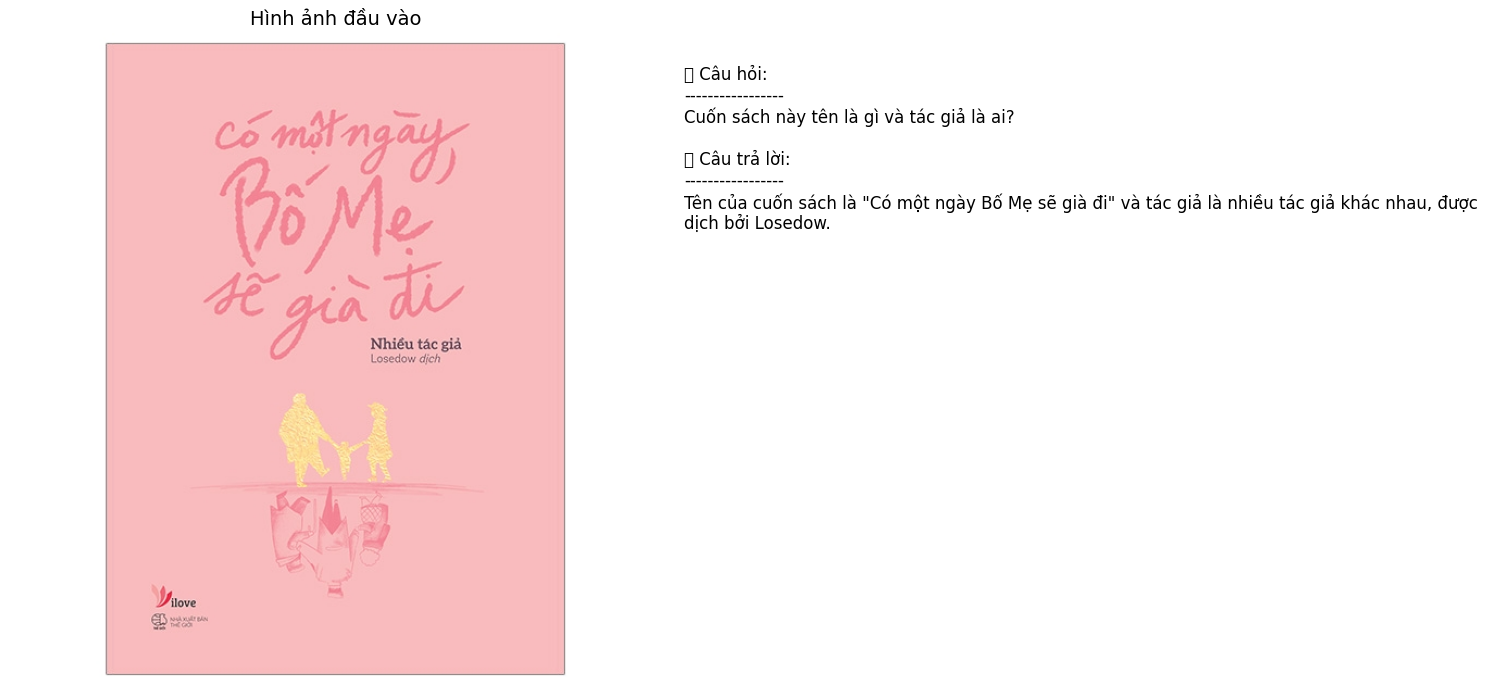


##################################################
Chạy thử với một ví dụ OCR
##################################################

🚀 Bắt đầu Inference...
📝 Câu hỏi: Cuốn sách trên tay bạn có tên là gì?


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🖼️ Đã tải ảnh từ: https://cdn0.fahasa.com/media/catalog/product/b/u/buoc_cham_lai_giua_the_gian_voi_va.u335.d20160817.t102115.612356.jpg
⏳ Đang tạo câu trả lời...
🤖 Câu trả lời: Tên của cuốn sách trên tay bạn là "Bước Chân Lại Giữa Thế Gian Vô Vai" của tác giả Hae Min.

✅ Inference hoàn tất!


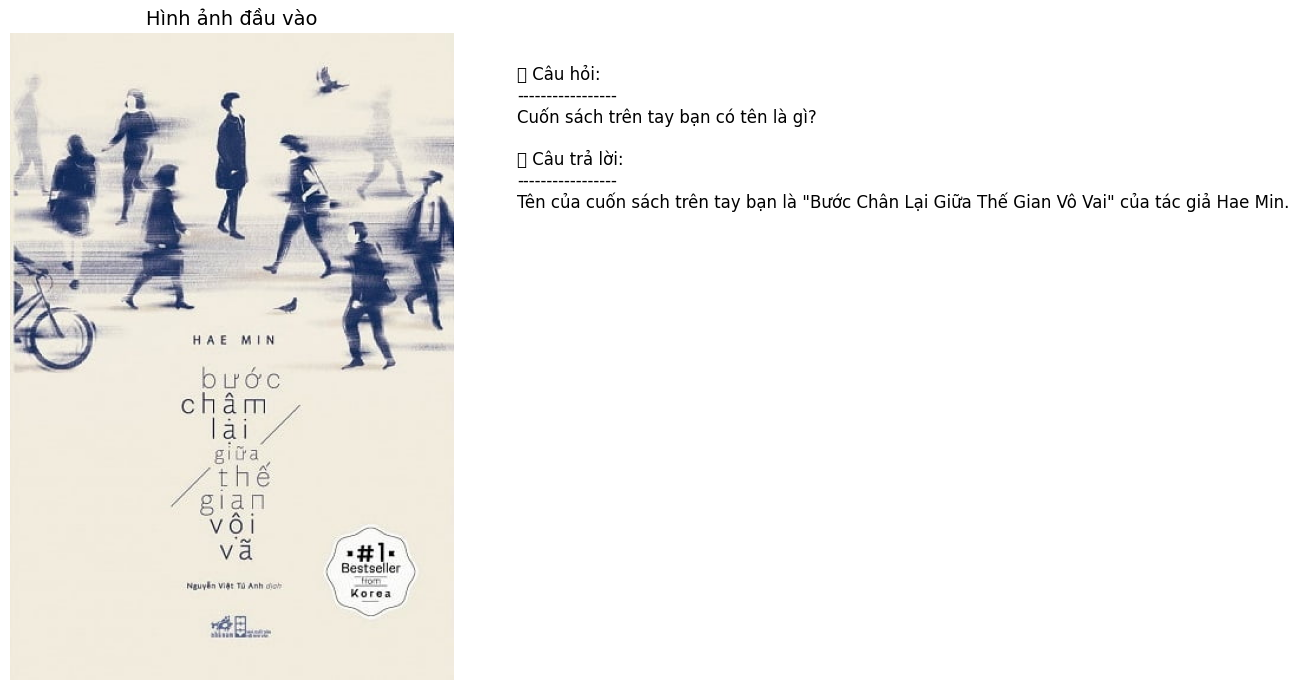

In [15]:
import torch
import random
from PIL import Image
import requests
from io import BytesIO
from transformers import AutoModelForImageTextToText, AutoProcessor # Sửa lại tên model
import matplotlib.pyplot as plt # <<< THÊM MỚI: Thư viện để vẽ

# --- 1. Thiết lập ---
# Thay đổi model_id thành model đã gộp cuối cùng của bạn nếu muốn
# model_id = "./qwen2.5-vl-lora-finetuned-custom-tokens/final-merged-model" 
BASE_MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
ADAPTER_ID = "sunbv56/qwen2.5-vl-vqa-vibook-tmp"
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🚀 Đang tải model và processor từ Hugging Face...")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
processor = AutoProcessor.from_pretrained(BASE_MODEL_ID, trust_remote_code=True)
model = AutoModelForImageTextToText.from_pretrained(
    BASE_MODEL_ID, 
    torch_dtype=dtype, 
    trust_remote_code=True
).to(device)
model = PeftModel.from_pretrained(model, ADAPTER_ID)
model = model.merge_and_unload()
model.eval()
print("✅ Model và Processor đã sẵn sàng!")


# <<< THÊM MỚI: Hàm để vẽ kết quả >>>
def visualize_inference(image: Image.Image, question: str, answer: str):
    """
    Hiển thị hình ảnh, câu hỏi và câu trả lời của model một cách trực quan.
    """
    plt.figure(figsize=(15, 7))

    # Cột 1: Hiển thị hình ảnh
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(image)
    ax1.set_title("Hình ảnh đầu vào", fontsize=14)
    ax1.axis('off')

    # Cột 2: Hiển thị văn bản
    ax2 = plt.subplot(1, 2, 2)
    ax2.axis('off')
    
    # Định dạng văn bản
    text_content = (
        f"❓ Câu hỏi:\n"
        f"-----------------\n"
        f"{question}\n\n"
        f"🤖 Câu trả lời:\n"
        f"-----------------\n"
        f"{answer}"
    )
    
    # Hiển thị văn bản với tính năng tự động xuống dòng
    ax2.text(0, 0.95, text_content,
             ha='left',          # Căn lề trái
             va='top',           # Căn lề trên
             fontsize=12,
             wrap=True)          # Tự động xuống dòng

    plt.tight_layout()
    plt.show()


# --- 2. Định nghĩa hàm Inference ---
# <<< THAY ĐỔI: Hàm này bây giờ sẽ trả về kết quả thay vì chỉ in ra >>>
def run_inference(question: str, image_url: str = None, local_image_path: str = None):
    """
    Chạy inference và trả về ảnh, câu hỏi và câu trả lời.
    """
    print("\n" + "="*50)
    print("🚀 Bắt đầu Inference...")
    print(f"📝 Câu hỏi: {question}")

    # Tải ảnh
    try:
        if local_image_path:
            image = Image.open(local_image_path).convert("RGB")
            print(f"🖼️ Đã tải ảnh từ: {local_image_path}")
        elif image_url:
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }
            response = requests.get(image_url, headers=headers, timeout=10)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content)).convert("RGB")
            print(f"🖼️ Đã tải ảnh từ: {image_url}")
        else:
            raise ValueError("Cần cung cấp image_url hoặc local_image_path.")
    except Exception as e:
        print(f"❌ Lỗi tải ảnh: {e}")
        return None, None, None # Trả về None nếu lỗi

    # Tạo messages
    messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": question}]}]
    prompt_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[prompt_text], images=[image], return_tensors='pt').to(device=device, dtype=model.dtype)

    print("⏳ Đang tạo câu trả lời...")
    with torch.no_grad():
        im_end_token = "<|im_end|>"
        eos_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids(im_end_token)]
        output_ids = model.generate(**inputs, max_new_tokens=128, do_sample=False, eos_token_id=eos_token_ids, pad_token_id=processor.tokenizer.pad_token_id)

    generated_ids = output_ids[0][inputs['input_ids'].shape[1]:]
    generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    print(f"🤖 Câu trả lời: {generated_text}")
    print("\n✅ Inference hoàn tất!")
    
    # Trả về các giá trị để có thể vẽ
    return image, question, generated_text

# --- 3. Chạy thử nghiệm với một ảnh ngẫu nhiên từ `eval_dataset` nếu có ---
# Bỏ qua phần này nếu bạn không có eval_dataset trong môi trường inference

# try:
#     # Giả sử eval_dataset đã được load
#     random_idx = random.randint(0, len(eval_dataset) - 1)
#     sample_raw = eval_dataset.dataset[random_idx]
#     test_question = sample_raw['conversations'][0]['value']
#     test_image_url = sample_raw.get("image_url", None)
#
#     # Chạy inference và vẽ kết quả
#     img, q, ans = run_inference(question=test_question, image_url=test_image_url)
#     if img: # Chỉ vẽ nếu inference thành công
#         visualize_inference(img, q, ans)
# except NameError:
#     print("⚠️ Không tìm thấy eval_dataset, bỏ qua test mẫu từ dataset.")


# --- 4. Chạy thử nghiệm tùy chỉnh ---
print("\n" + "#"*50)
print("Chạy thử với một ví dụ tùy chỉnh")
print("#"*50)
custom_url = "https://cdn0.fahasa.com/media/catalog/product/c/o/co-mot-ngay-bo-me-se-gia-di.jpg"
custom_question = "Cuốn sách này tên là gì và tác giả là ai?"

# Chạy inference
img, q, ans = run_inference(question=custom_question, image_url=custom_url)

# Vẽ kết quả nếu thành công
if img:
    visualize_inference(img, q, ans)

# Ví dụ 2
print("\n" + "#"*50)
print("Chạy thử với một ví dụ OCR")
print("#"*50)
custom_url_2 = "https://cdn0.fahasa.com/media/catalog/product/b/u/buoc_cham_lai_giua_the_gian_voi_va.u335.d20160817.t102115.612356.jpg"
custom_question_2 = "Cuốn sách trên tay bạn có tên là gì?"

# Chạy inference
img_2, q_2, ans_2 = run_inference(question=custom_question_2, image_url=custom_url_2)

# Vẽ kết quả nếu thành công
if img_2:
    visualize_inference(img_2, q_2, ans_2)